In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Prepare data

## Load dataset

In [3]:
import pickle

PICKLE_PATH = "allocine_dataset/data/allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

# Reviews need to be tokenized
train_reviews = np.array(data["train_set"]['review'])
val_reviews = np.array(data["val_set"]['review'])
test_reviews = np.array(data["test_set"]['review'])

train_labels = data["train_set"]['polarity']
val_labels = data["val_set"]['polarity']
test_labels = data["test_set"]['polarity']
class_names = data['class_names']

## Preprocess dataset

In [31]:
train_reviews = train_reviews[:1000]
val_reviews = val_reviews[:1000]
test_reviews = test_reviews[:1000]

train_labels = train_labels[:1000]
val_labels = val_labels[:1000]
test_labels = test_labels[:1000]

### Tokenize

In [4]:
from transformers import CamembertTokenizer

model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)

In [8]:
some_review = train_reviews[0]
some_review

'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvement

In [9]:
tokenizer.tokenize(some_review)[:15]

['▁Si',
 '▁vous',
 '▁cherchez',
 '▁du',
 '▁cinéma',
 '▁abruti',
 'ssant',
 '▁à',
 '▁tous',
 '▁les',
 '▁étages',
 ',',
 'n',
 "'",
 'ayant']

In [10]:
tokenizer.encode(some_review)[:15]

[5, 168, 39, 3162, 25, 1545, 29470, 2927, 15, 117, 19, 9339, 7, 255, 11]

In [11]:
tokenizer.decode(tokenizer.encode(some_review))

'<s> Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouve

Average length: 126.2
Max length: 512


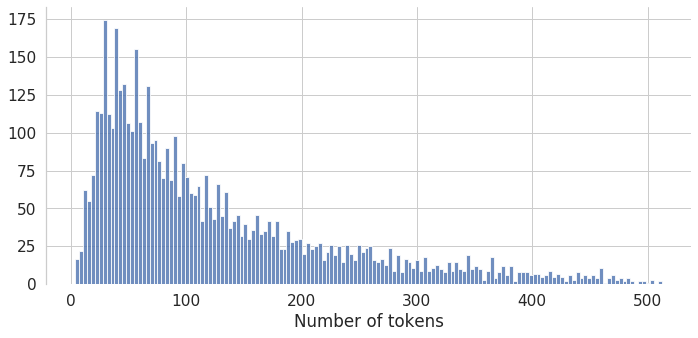

In [8]:
reviews_len = [len(tokenizer.encode(review, max_length=512))
                          for review in train_reviews]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of tokens')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/bert/number_of_tokens.png', dpi=200)

In [11]:
tokenizer.vocab_size

32005

In [13]:
import numpy as np

def encode_reviews(tokenizer, reviews, max_length):
    token_ids = np.zeros(shape=(len(reviews), max_length),
                         dtype=np.int32)
    for i, review in enumerate(reviews):
        encoded = tokenizer.encode(review, max_length=max_length)
        token_ids[i, 0:len(encoded)] = encoded
    attention_mask = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_mask": attention_mask}

In [11]:
MAX_SEQ_LEN = 400 # in terms of generated tokens (not words)

In [32]:


encoded_train = encode_reviews(tokenizer, train_reviews, MAX_NB_TOKEN)
encoded_valid = encode_reviews(tokenizer, val_reviews, MAX_NB_TOKEN)
encoded_test = encode_reviews(tokenizer, test_reviews, MAX_NB_TOKEN)

### Labels

In [33]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

### Preprocessing pipeline

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class CamembertPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, max_seq_length):
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def fit(self, X=None):
        pass
    
    def transform(self, X, y):
        # 1. Tokenize
        X_encoded = encode_reviews(self.tokenizer, X, self.max_seq_length)
        # 2. Labels
        y_array = np.array(y)
        return X_encoded, y_array     
    
    def fit_transform(self, X, y):        
        return self.transform(X, y)

# Model

In [6]:
from transformers import TFCamembertForSequenceClassification

model = TFCamembertForSequenceClassification.from_pretrained("jplu/tf-camembert-base")

opt = tf.keras.optimizers.Adam(learning_rate=1e-6, epsilon=1e-08)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)    

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

In [7]:
initial_weights = model.get_weights()
model.summary()

Model: "tf_camembert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  110621952 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  592130    
Total params: 111,214,082
Trainable params: 111,214,082
Non-trainable params: 0
_________________________________________________________________


# Training

In [34]:
history = model.fit(
    encoded_train, y_train, epochs=1, batch_size=4, 
    validation_data=(encoded_valid, y_val), verbose=1
)

Train on 1000 samples, validate on 1000 samples
1000/1000 [==============================] - 121s 121ms/sample - loss: 0.3054 - accuracy: 0.9290 - val_loss: 0.2387 - val_accuracy: 0.9530


# Testing

# Accuracy vs Training Data

In [8]:
from sklearn.base import BaseEstimator

class EarlyStoppingModel(BaseEstimator):
    def __init__(self, transformers_model, max_epoches, batch_size, validation_data):
        self.model = transformers_model
        self.max_epoches = max_epoches
        self.batch_size = batch_size
        self.validation_data = validation_data
        
    def fit(self, X, y):
        # Defines early stopper
        early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', mode='auto', patience=1, # only 1 !
            verbose=1, restore_best_weights=True
        )        

        # Train model on data subset
        self.model.fit(
            X, y,
            validation_data=self.validation_data,
            epochs=self.max_epoches, 
            batch_size=self.batch_size,
            callbacks=[early_stopper], 
            verbose=1
        )        
        return self
    
    def predict(self, X):        
        scores = self.model.predict(X)
        y_pred = np.argmax(scores, axis=1)
        return y_pred

In [17]:
from sklearn import metrics 

def accuracy_vs_training_data(camembert_model, initial_weights, 
                              preprocessor, sizes,
                              train_reviews, train_labels,
                              val_reviews, val_labels,
                              test_reviews, test_labels):
    test_accuracies = []
    for size in sizes:        
        # Preprocess data
        X_train, y_train = preprocessor.fit_transform(
            train_reviews[:size], train_labels[:size]
        )
        X_val, y_val = preprocessor.transform(val_reviews, val_labels)
        X_test, y_test = preprocessor.transform(test_reviews, test_labels)
        
        # Reset weights to initial value
        camembert_model.set_weights(initial_weights)
        best_model = EarlyStoppingModel(
            camembert_model, max_epoches=7, batch_size=4,
            validation_data=(X_val, y_val)
        )
        
        # Train model
        best_model.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        test_acc = metrics.accuracy_score(y_test, y_pred)
        test_accuracies.append(test_acc)
        print("Test acc: " + str(test_acc))
        
    return test_accuracies    

In [18]:
#sizes = [int(p) for p in np.geomspace(1000, 160000, 10)]
sizes = [1000, 2000, 3000, 4000, 5000]
preprocessor = CamembertPreprocessor(tokenizer, MAX_SEQ_LEN)

test_accuracies = accuracy_vs_training_data(
    model, initial_weights, 
    preprocessor, sizes,
    train_reviews, train_labels,
    val_reviews[:5000], val_labels[:5000],
    test_reviews[:5000], test_labels[:5000]
)

Train on 1000 samples, validate on 5000 samples
Epoch 1/7
1000/1000 [==============================] - 235s 235ms/sample - loss: 0.6934 - accuracy: 0.5010 - val_loss: 0.6902 - val_accuracy: 0.6686
Epoch 2/7
1000/1000 [==============================] - 229s 229ms/sample - loss: 0.6876 - accuracy: 0.6110 - val_loss: 0.6832 - val_accuracy: 0.7116
Epoch 3/7
1000/1000 [==============================] - 229s 229ms/sample - loss: 0.6765 - accuracy: 0.7400 - val_loss: 0.6589 - val_accuracy: 0.8762
Epoch 4/7
1000/1000 [==============================] - 229s 229ms/sample - loss: 0.6095 - accuracy: 0.8990 - val_loss: 0.4965 - val_accuracy: 0.9348
Epoch 5/7
1000/1000 [==============================] - 229s 229ms/sample - loss: 0.4448 - accuracy: 0.9250 - val_loss: 0.3447 - val_accuracy: 0.9418
Epoch 6/7
1000/1000 [==============================] - 229s 229ms/sample - loss: 0.3315 - accuracy: 0.9410 - val_loss: 0.2775 - val_accuracy: 0.9430
Epoch 7/7
1000/1000 [==============================] - 229

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[4,400,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node tf_camembert_for_sequence_classification/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/mul_2 (defined at /home/theophile/.local/share/virtualenvs/french_sentiment_analysis_with_bert-quJAe4Xa/lib/python3.7/site-packages/transformers/modeling_tf_bert.py:338) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Reshape_520/_42]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[4,400,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node tf_camembert_for_sequence_classification/roberta/encoder/layer_._11/output/LayerNorm/batchnorm/mul_2 (defined at /home/theophile/.local/share/virtualenvs/french_sentiment_analysis_with_bert-quJAe4Xa/lib/python3.7/site-packages/transformers/modeling_tf_bert.py:338) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_27660]

Function call stack:
distributed_function -> distributed_function


In [72]:
from transformers import TFCamembertModel
from tensorflow.keras.layers import Dropout, Dense, Activation


class ClassificationModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, model_name="jplu/tf-camembert-base",
                 dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFCamembertModel.from_pretrained(model_name)
        
        # Classification head
        self.dropout_1 = tf.keras.layers.Dropout(dropout_prob)
        #self.linear_1 = tf.keras.layers.Dense(768)
        #self.activation = tf.keras.layers.Activation('tanh')
        #self.dropout_2 = tf.keras.layers.Dropout(dropout_prob)
        self.linear_2 = tf.keras.layers.Dense(2)

    def call(self, inputs, **kwargs):
        sequence_output, pooled_output = self.bert(inputs, **kwargs)

        x = self.dropout_1(pooled_output, training=kwargs.get("training", False))        
        #x = self.linear_1(x)
        #x = self.activation(x)
        #x = self.dropout_2(x, training=kwargs.get("training", False))
        logits = self.linear_2(x)
        return logits

# TODO: see https://huggingface.co/transformers/v2.1.1/_modules/transformers/modeling_tf_roberta.html#TFRobertaForSequenceClassification
intent_model = ClassificationModel()

In [73]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)    
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)

intent_model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

In [9]:
from transformers import TFCamembertForSequenceClassification

model = TFCamembertForSequenceClassification.from_pretrained("jplu/tf-camembert-base")

opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)    

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

In [ ]:
model.summary()

In [103]:
# Trained with max length = 200, val_accuracy = 0.9489 after 2 epochs
history = model.fit(
    encoded_train, y_train, epochs=10, batch_size=8, 
    validation_data=(encoded_valid, y_val), verbose=1
)

Train on 12000 samples, validate on 4000 samples
Epoch 1/10
12000/12000 [==============================] - 569s 47ms/sample - loss: 0.2662 - accuracy: 0.8785 - val_loss: 0.1659 - val_accuracy: 0.9366
Epoch 2/10
12000/12000 [==============================] - 571s 48ms/sample - loss: 0.1176 - accuracy: 0.9565 - val_loss: 0.1431 - val_accuracy: 0.9489
Epoch 3/10
 1184/12000 [=>............................] - ETA: 7:47 - loss: 0.0858 - accuracy: 0.9707

KeyboardInterrupt: 

In [11]:
history = model.fit(
    encoded_train, y_train, epochs=30, batch_size=3, 
    validation_data=(encoded_valid, y_val), verbose=1
)

Train on 12000 samples, validate on 4000 samples
Epoch 1/30
12000/12000 [==============================] - 1634s 136ms/sample - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
12000/12000 [==============================] - 1631s 136ms/sample - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 3/30
12000/12000 [==============================] - 1635s 136ms/sample - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6967 - val_accuracy: 0.5000
Epoch 4/30
12000/12000 [==============================] - 1637s 136ms/sample - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/30
12000/12000 [==============================] - 1638s 137ms/sample - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 6/30
12000/12000 [==============================] - 1638s 136ms/sample - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 7/30
12000/12000 [=========

KeyboardInterrupt: 

In [ ]:
y_train